Xinyuan Chen HW3 (baseline)

## Approach

Find a weight for Jaccard similarity (see [baseline.ipynb](./baseline.ipynb)) and recipe popularity percentile (see [baselines.ipy](./baselines.py)), and calculate the weighed average.

If the weighed average >= a value we set (here we use 0.5), the user_id and recipe_id combination is predicted to be actually have happened.
## Baseline

An alternate baseline than the one provided might make use of the Jaccard similarity (or another similarity metric). Given a pair (u,g) in the validation set, consider all training items g′that user u has
cooked. For each, compute the Jaccard similarity between g and g′, i.e., users (in the training set) who
have made g and users who have made g′. Predict as ‘made’ if the maximum of these Jaccard similarities
exceeds a threshold.

There are 500,000 entries in the csv file, we use 2% of them (10,000 entries) as the validation dataset, and generate another 10,000 random combination of user_id and recipe_id and add them to the validation set.

### The goal 

Determine an optimal `threshold` for the Jaccard similarity for this binary classification problem.


In [12]:
from typing import Literal
ResultType = Literal[0, 1]
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import genfromtxt
my_data = genfromtxt('trainInteractions.csv', delimiter=',', dtype=int, skip_header=1)
d = my_data
# drop the last 2 columns of d
d = d[:,:-2]
y = np.ones((500_000, 1), dtype=int)
X_train, X_test, y_train, y_test = train_test_split(d,
                                                    y,
                                                    test_size=0.02,
                                                    random_state=42)
[x.shape for x in (X_train, X_test, y_train, y_test)]

[(490000, 2), (10000, 2), (490000, 1), (10000, 1)]

In [4]:
from collections import defaultdict
user_cooked_set_train = defaultdict(set)
recipe_to_users_train = defaultdict(set)

for u, r in X_train:
	user_cooked_set_train[u].add(r)
	recipe_to_users_train[r].add(u)

In [10]:
def jaccard(a: set, b: set) -> float:
	return len(a.intersection(b)) / len(a.union(b))

def jaccard_sim_max(user_id: int, recipe_id: int) -> float:
    recipes_cooked_by_user_id = user_cooked_set_train[user_id]
    users_that_used_recipe_id = recipe_to_users_train[recipe_id]
    return max((jaccard(users_that_used_recipe_id, recipe_to_users_train[r])
                for r in recipes_cooked_by_user_id),
               default=.0)


def gen_random_validation_set(
        X_train: np.ndarray,
        user_cooked_set_train: dict[int,
                                    set]) -> tuple[int, int]:  # type: ignore
    # already_done = True
    while 1:
        # choose a random user from the first column in X_train
        user_id = np.random.choice(X_train[:, 0])
        recipe_id = np.random.choice(X_train[:, 1])
        if recipe_id not in user_cooked_set_train[user_id]:
            # already_done = False
            return user_id, recipe_id

def max_sim_to_result(max_sim: float, threshold: float, expected: ResultType) -> bool:
	if max_sim >= threshold:
		result = 1
	else:
		result = 0
	return result == expected

In [21]:
random_list: list[tuple[int, int]] = [
    gen_random_validation_set(X_train, user_cooked_set_train)
    for _ in range(X_test.shape[0])
]
X_random = np.array(random_list)
# X_random.shape
X_test_and_random = np.vstack((X_test, X_random))
# X_test_and_random.shape
Y_random = np.array([[0] for _ in range(X_random.shape[0])])
# Y_random.shape, y_test.shape

y_test_and_random = np.vstack((y_test, Y_random))
# y_test_and_random.shape
y_test_and_random.reshape((y_test_and_random.shape[0],))
# y_test_and_random.shape
y_test_and_random[(X_random.shape[0] - 2):(X_random.shape[0] + 2), :]
y_test_and_random.resize((y_test_and_random.shape[0],))
y_test_and_random.shape

(20000,)

In [7]:
jaccard_max_sims = [jaccard_sim_max(u, r) for u, r in X_test_and_random]

In [11]:
len(jaccard_max_sims)

20000

In [15]:
def plot_accuracies(start, stop, step):
	accuracies: list[tuple[float, float]] = []
	for threshold in np.arange(start, stop, step):
		predictions_binary = [max_sim_to_result(x, threshold, y_test_and_random[i]) for i, x in enumerate(jaccard_max_sims)]
		accuracy = sum(predictions_binary) / len(predictions_binary)
		accuracies.append((threshold, accuracy))
	plt.scatter(*zip(*accuracies)) # type: ignore
	plt.show()

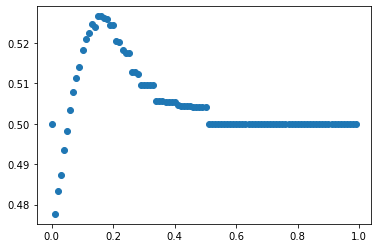

In [22]:
plot_accuracies(0.0, 1.0, 0.01)

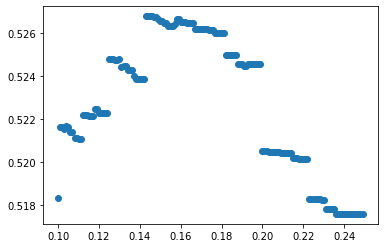

In [19]:
plot_accuracies(0.1, 0.25, 0.001)

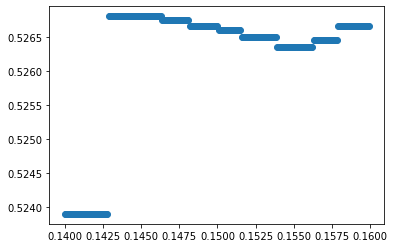

In [20]:
plot_accuracies(0.14, 0.16, 0.0001)

### Result

Here we choose the optimal `threshold` for Jaccard similarity as `0.1430`.